# Connect and authorize google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls

In [ ]:
# %cd /content/gdrive/My Drive/
%cd /content/gdrive/My Drive/Colab Notebooks/ML/data
!ls

In [ ]:
! pwd

/content/gdrive/My Drive/Colab Notebooks/ML/data


In [ ]:
! pip install keras-vis

# Install

In [ ]:
! pip install reproject

In [ ]:
! pip install healpy
! pip install reproject

In [ ]:
! pip install tqdm

In [ ]:
! pip install spectral_cube

# Libraries

In [ ]:
import sys, os

import numpy as np
from keras import models

from astropy.io          import fits
from astropy             import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.wcs import WCS
from astropy.table import Table


from scipy.interpolate import interp1d

import healpy as hp

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


import glob
import pickle
from tqdm import tqdm

from pathlib import Path

from spectral_cube import SpectralCube
from reproject import reproject_from_healpix, reproject_to_healpix

In [ ]:
import keras
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Convolution1D, Dense, Dropout, Flatten, Input, Dense
# from vis.utils import utils

from sklearn.model_selection import KFold
from keras.models import load_model

# fix random seed for reproducibility
seed = 1234
np.random.seed(seed)

In [ ]:
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'

# Paths

In [ ]:
base_path = Path('/content/gdrive/MyDrive/Colab Notebooks/ML')

tano_signal_path = base_path / 'tano_signal' / 'tano_signal'
checkpoint_path  = tano_signal_path / 'checkpoints'
ct101_checkpoint_path = checkpoint_path / 'c101'
cnn101_checkpoint_path = checkpoint_path / 'cnn' / 'c101'

data_path     = base_path / 'data'
uma_data_path = data_path / 'UMA'
misc_path     = base_path / 'misc'
galfa_path    = data_path / 'GALFA'

tanosignal_path  = base_path / 'tano_signal'
tanosignal_pred_path = tanosignal_path / 'pred'

training_data_pkl_file = data_path / 'training_data_kok14_galfa.pickle'
fcnm_cnn_file = data_path / 'fcnm_zea.fits'
rhi_cnn_file = data_path / 'rhi_zea.fits'
observed_catalog_file = data_path / 'catalogged_verification.fits'

model_path = base_path / 'models'

print(tano_signal_path)
print(checkpoint_path)
print(ct101_checkpoint_path)
print(cnn101_checkpoint_path)
print('UMA: ', uma_data_path)

# Utils

In [ ]:
def read_fits_cube(filename):
    """
    Read

    Parameters
    ----------
    filename (string) : filename of FITS file
    Input data.

    Returns
    -------
    cube
    WCS
    X-coordinates
    Y-coordinates
    Velocity

    Other parameters
    ----------------
    None
    """

    # Read FITS file
    dat = fits.open(filename)  # Open the FITS file for reading
    c = SpectralCube.read(dat)  # Initiate a SpectralCube


    # Parse the WCS keywords in the primary HDU
    hdr = dat[0].header

    w = WCS(naxis=2)
    w.wcs.crpix = [hdr['CRPIX1'], hdr['CRPIX2']]
    w.wcs.cdelt = np.array([hdr['CDELT1'], hdr['CDELT2']])
    w.wcs.crval = [hdr['CRVAL1'], hdr['CRVAL2']]
    w.wcs.ctype = [hdr['CTYPE1'], hdr['CTYPE2']]


    dat.close()

    print(f"Cube shape: {c.shape}")

    del dat

    _, _, x = c.world[0, 0, :]    # extract RA
    _, y, _ = c.world[0, :, 0]    # extract DEC
    v, _, _ = c.world[:, 0, 0]    # extract velocity

    return c, w, x, y, v, hdr

In [ ]:
def get_val_pix(datmap, x, y, w):
    # Convert world coordinates to pixel coordinates
    xpix, ypix = w.world_to_pixel_values(x, y)

    # Round pixel coordinates to nearest integer
    xpix = [int(round(xi)) for xi in xpix]
    ypix = [int(round(yi)) for yi in ypix]

    # Access data array using the computed pixel coordinates
    value = datmap[ypix, xpix]

    return value, xpix, ypix

In [ ]:
def mean2vel(CRVAL, CDELT, CRPIX, mean):
    vel = [(CRVAL + CDELT * (mean[i] - CRPIX)) for i in range(len(mean))]
    return vel

# Download data

In [ ]:
# Download external data:
download = False
if download:
    # Training and test spectra
    !wget -O training_data_kok14_galfa.pickle https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/QT6NPF/79N7YU
    # fCNM CNN maps and uncertainties
    !wget -O fcnm_zea.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/E0HLON/28QM9F
    # RHI CNN maps and uncertainties
    !wget -O rhi_zea.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/E0HLON/WJZMPD
    # Observed catalog
    !wget -O catalogged_verification.fits https://dataverse.harvard.edu/api/access/datafile/:persistentId?persistentId=doi:10.7910/DVN/MJGQAY/D2RS4E

In [ ]:
!pwd

/content/gdrive/MyDrive/Colab Notebooks/ML/data


# Read training dataset

In [ ]:
data = pickle.load(open(training_data_pkl_file, 'rb'))

# Synthetic training data
X_train = data['X_train']
Y_train = data['Y_train']

# Observed test data
X_test = data['X_test']
Y_test = data['Y_test']

# Re-shape network inputs
X_train = X_train.reshape(X_train.shape[0],  X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],  X_test.shape[1], 1)

In [ ]:
X_train.shape

(38781, 414, 1)

In [ ]:
X_test.shape

(58, 414, 1)

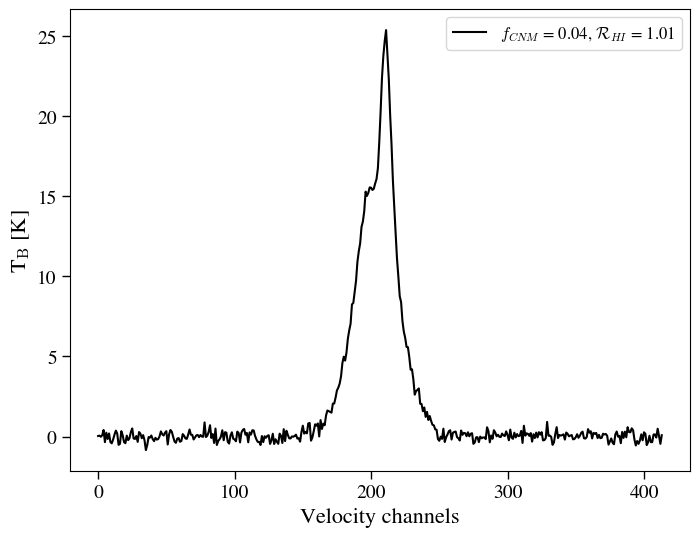

In [ ]:
# Spectrum in training set
# plt.figure(figsize=(8,6))
fig, ax = plt.subplots(figsize=(8,6))
spec_id = 0
fcnm_i = round(Y_train[spec_id, 0], 2)
rhi_i  = round(Y_train[spec_id, 1], 2)
# plt.plot(data[:, j, i], label='data')
ax.plot(X_train[spec_id, :, 0], 'k-', label=r'$f_{CNM}$ = '+str(fcnm_i)+', $\mathcal{R}_{HI}$ = '+str(rhi_i))

# plt.title('Training set')
ax.set_xlabel('Velocity channels', fontsize=16)
ax.set_ylabel('T$_\mathrm{B}$ [K]', fontsize=16)
ax.tick_params(axis='both', which='both', length=6, width=1, labelsize=14)

plt.legend(loc='upper right', fontsize=12)

plt.show()

# Build and train the convolutional neural network

Construct the 1D CNN, compile it, and fit the parameters using the training data.

In [ ]:
batch_size = 16
num_epochs = 128

cnn = Sequential((
    Convolution1D(8, 6, activation='relu', input_shape=X_train.shape[1:3],name = 'firstconv'),
    Convolution1D(8, 40, activation='relu', name = 'midconv'),
    Flatten(),
    Dropout(0.3),
    Dense(2, activation='linear', name = 'preds'),
))
cnn.compile(loss='mse', optimizer='adam')

# cnn.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs, verbose=1,  validation_split=0.3)

In [ ]:
if False:
  # define 10-fold cross validation test harness
  kf = KFold(n_splits=10)
  kf.get_n_splits(X_train)

  cvscores = []
  for i, (train_index, val_index) in tqdm(enumerate(kf.split(X_train, Y_train.argmax(1)))):
      x_train_kf, x_val_kf = X_train[train_index], X_train[val_index]
      y_train_kf, y_val_kf = Y_train[train_index], Y_train[val_index]

      cnn_kf = Sequential((
          Convolution1D(8, 6, activation='relu', input_shape=x_train_kf.shape[1:3]),
          Convolution1D(8, 40, activation='relu'),
          Flatten(),
          Dropout(0.3),
          Dense(2, activation='linear'),
      ))
      cnn_kf.compile(loss='mse', optimizer='adam', metrics=['mae','acc'])

      cnn_kf.fit(x_train_kf, y_train_kf, epochs=num_epochs, batch_size=batch_size, verbose=1)

      # evaluate the model
      scores = cnn_kf.evaluate(x_val_kf, y_val_kf, verbose=0)
      print("%s: %.2f%%" % (cnn_kf.metrics_names[1], scores[1]*100))

      cvscores.append(scores[1] * 100)

In [ ]:
# print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

# Apply trained model to observed data

In [ ]:
if False:
  # Generate predictions
  Y_pred = cnn_kf.predict(X_test)
  Y_pred.shape

In [ ]:
if False:
  # Set the font family for math symbols
  plt.rcParams["mathtext.fontset"] = "custom"
  plt.rcParams["mathtext.rm"] = "Times New Roman"
  plt.rcParams["mathtext.it"] = "Times New Roman:italic"
  plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

  fig = plt.figure(figsize=(12,8))
  ax = fig.add_subplot(111)


  color_ = 'k'
  sct1 = ax.scatter(Y_test[:,1], Y_pred[:,1],
                    zorder=2, s=8,
                    marker='o', c=color_, vmin=0., vmax=37.,
                    facecolors='none', edgecolors=color_,
                    label=f'Test: {len(Y_pred[:,0])}')

  ax.set_xlabel(r'Ground truth $\mathcal{R}_{HI}$ (from observation)', fontsize=16)
  ax.set_ylabel(r'Prediction $\mathcal{R}_{HI}$ (CNN model)', fontsize=18)

  ax.tick_params(axis='x', labelsize=12, pad=4)
  ax.tick_params(axis='y', labelsize=12)
  ax.tick_params(which='both', width=2)
  ax.tick_params(which='major', length=4)
  ax.tick_params(which='minor', length=2)

  plt.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
  plt.legend(loc='lower right', fontsize=10)

  plt.show()

In [ ]:
# Save the trained model
trained_cnn_model = model_path / 'trained_model.keras'

if False:
  cnn_kf.save(trained_cnn_model)

# Load trained model

In [ ]:
loaded_model = load_model(trained_cnn_model)

In [ ]:
if False:
  # Generate predictions
  Y_pred = loaded_model.predict(X_test)
  Y_pred.shape

In [ ]:
if False:
  # Set the font family for math symbols
  plt.rcParams["mathtext.fontset"] = "custom"
  plt.rcParams["mathtext.rm"] = "Times New Roman"
  plt.rcParams["mathtext.it"] = "Times New Roman:italic"
  plt.rcParams["mathtext.bf"] = "Times New Roman:bold"

  fig = plt.figure(figsize=(12,8))
  ax = fig.add_subplot(111)


  color_ = 'k'
  sct1 = ax.scatter(Y_test[:,0], Y_pred[:,0],
                    zorder=2, s=8,
                    marker='o', c=color_, vmin=0., vmax=37.,
                    facecolors='none', edgecolors=color_,
                    label=f'Test: {len(Y_pred[:,0])}')

  ax.set_xlabel(r'Ground truth $f_{CNM}$ (from observation)', fontsize=16)
  ax.set_ylabel(r'Prediction $f_{CNM}$ (CNN model)', fontsize=18)

  ax.tick_params(axis='x', labelsize=12, pad=4)
  ax.tick_params(axis='y', labelsize=12)
  ax.tick_params(which='both', width=2)
  ax.tick_params(which='major', length=4)
  ax.tick_params(which='minor', length=2)

  plt.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)
  plt.legend(loc='lower right', fontsize=10)

  plt.show()

# HI4PI data

In [ ]:
hi4pi_data_path = data_path / 'ivc'
hi4pi_data_path

In [ ]:
# Training and test datasets
file_name = 'Tb_HI4PI_135_55_anomalous.fits'
print(file_name)

Tb_HI4PI_135_55_anomalous.fits


In [ ]:
data_file = hi4pi_data_path / file_name
data_file

In [ ]:
hdu[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
NAXIS3  =                  139                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               

In [ ]:
#Load v array
hdu = fits.open(data_file)
hdu.info()
hdu[0].header
v = np.array(mean2vel(hdu[0].header["CRVAL3"], hdu[0].header["CDELT3"], hdu[0].header["CRPIX3"], np.arange(139))) * 1.e-3 # to km/s

In [ ]:
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
CRPIX1  =                128.0                                                  
CRVAL1  =                135.0                                                  
CDELT1  =                -0.05                                                  
CTYPE1  = 'GLON-TAN'                                                            
CRPIX2  =                128.0                                                  
CRVAL2  =                 55.0                                                  
CDELT2  =                 0.05                                                  
CTYPE2  = 'GLAT-TAN'                                                            
CRPIX3  =                   

In [ ]:
dv = 1.28821496912415 # km/s

In [ ]:
data, hdr = fits.getdata(data_file, header=True)
data.shape

(139, 256, 256)

In [ ]:
hdr

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  256                                                  
NAXIS2  =                  256                                                  
NAXIS3  =                  139                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               

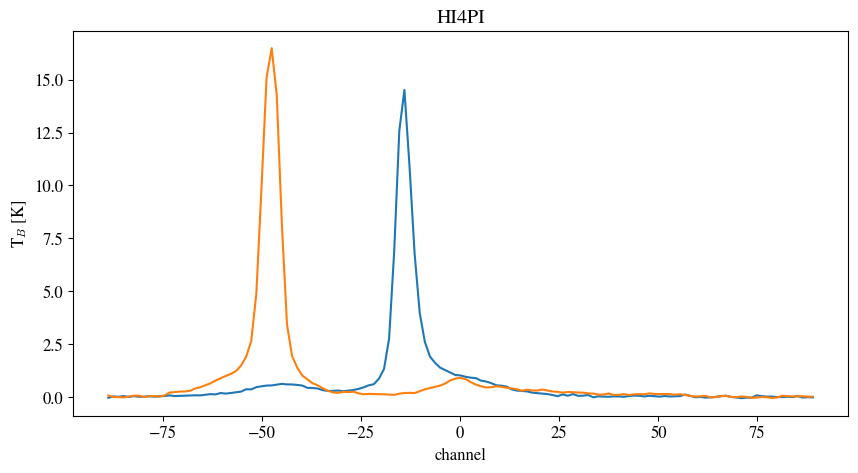

In [ ]:
fig = plt.figure(figsize=(10,5))


# IVC (-50km/s) and a small part that is not a part of the IVC (-10 km/s)
plt.plot(v, data[:, 1, 40])
plt.plot(v, data[:, 120, 125])

plt.title('HI4PI')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

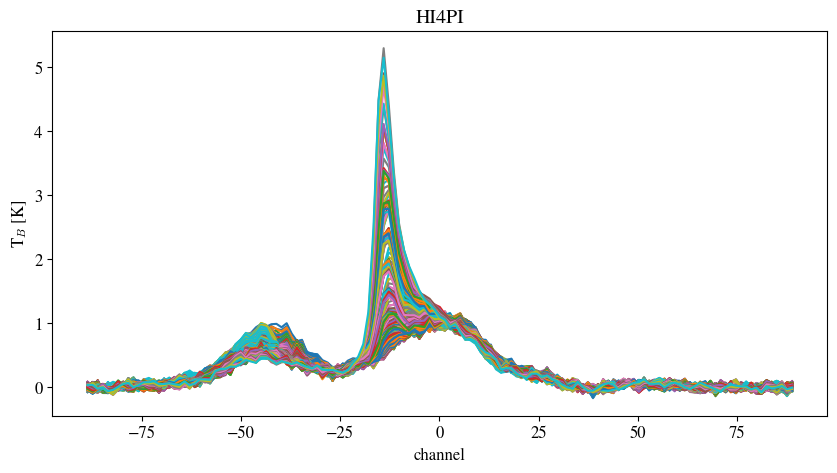

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(v, data[:, j, i])

plt.title('HI4PI')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(data[:, j, i])

plt.title('HI4PI')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

In [ ]:
nchan, ny, nx = data.shape
print(nchan, ny, nx)

139 256 256


In [ ]:
tb_sum = np.sum(data, axis=0)
nhi_thin = tb_sum * 0.018224* dv

In [ ]:
num = ny*nx
num

65536

In [ ]:
# TB max
tbmax_map = np.max(data, axis=0)
tbmax_flat = tbmax_map.flatten()

# To new channel grid

In [ ]:
x = np.linspace(0, nchan, nchan, endpoint=False)
x[-3:]

array([136., 137., 138.])

In [ ]:
# Interpolate into new vlsr channel grid
nchan_new = 414
x_new = np.linspace(0, nchan, nchan_new, endpoint=True)
print(x_new[-3:])
print(x_new.shape)

new_cube = np.zeros((nchan_new, ny, nx))
for i,j in np.ndindex(nx,ny):
    new_cube[:, j, i] = np.interp(x_new, x, data[:, j, i])

[138.32687651 138.66343826 139.        ]
(414,)


In [ ]:
new_cube.shape

(414, 256, 256)

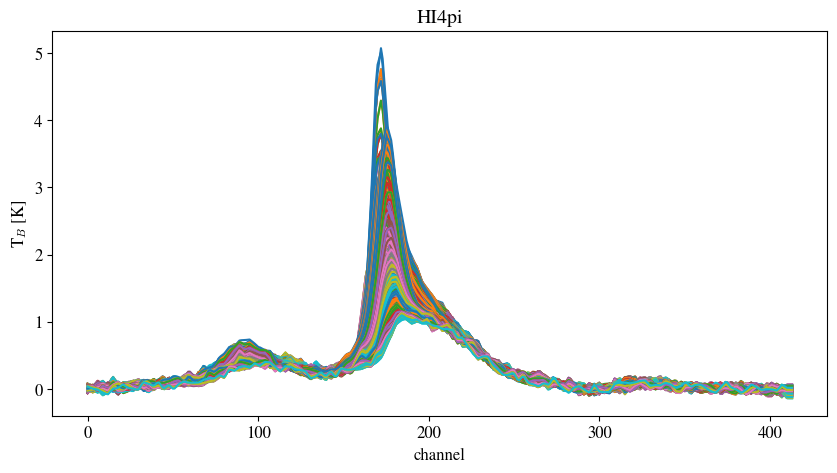

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(new_cube[:, 20+j, 20+i])

plt.title('HI4pi')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')   # save the figure to file
plt.show()

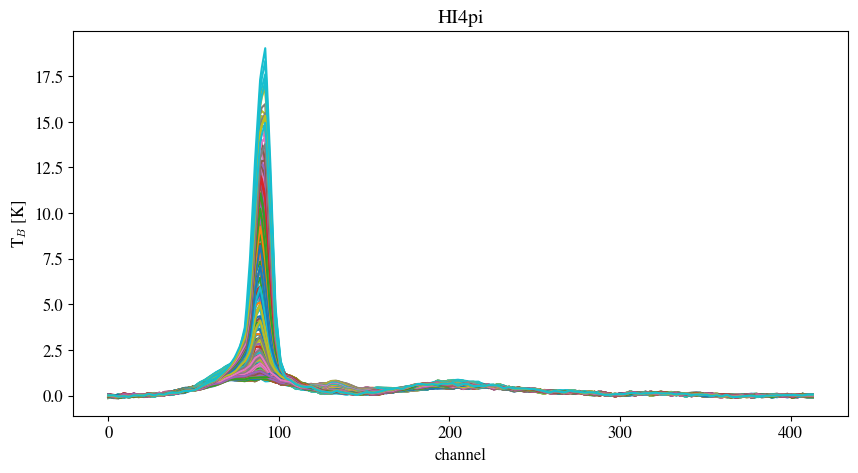

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(new_cube[:, 80+j, 80+i])

plt.title('HI4pi')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')
plt.show()

In [ ]:
X_data = np.zeros((nx*ny, 414, 1))
X_data.shape

(65536, 414, 1)

In [ ]:
k = 0
for (i,j) in np.ndindex(nx,ny):
  X_data[k, :, 0] = new_cube[:, j, i]
  k = k + 1

In [ ]:
Y_data_pred = loaded_model.predict(X_data)
Y_data_pred

2048/2048 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step


array([[0.00727808, 1.0006331 ],
       [0.00727808, 1.0006331 ],
       [0.00727808, 1.0006331 ],
       ...,
       [0.00727808, 1.0006331 ],
       [0.00727808, 1.0006332 ],
       [0.00727808, 1.0006332 ]], dtype=float32)

In [ ]:
Y_data_pred_maps = np.reshape(Y_data_pred.copy(), (ny,nx,2), order='F')
Y_data_pred_maps.shape

(256, 256, 2)

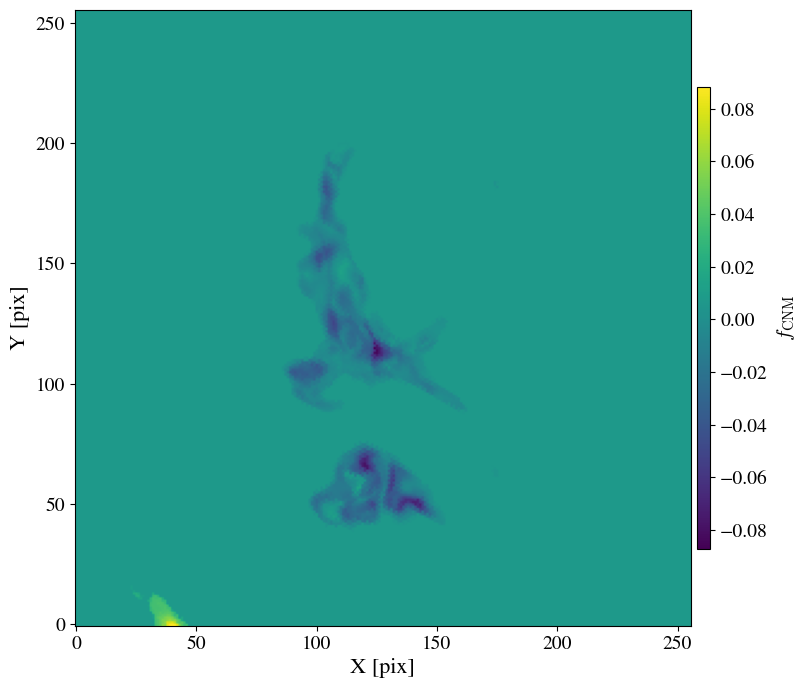

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(Y_data_pred_maps[:,:,0], cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [pix]", fontsize=16)
ax.set_ylabel("Y [pix]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

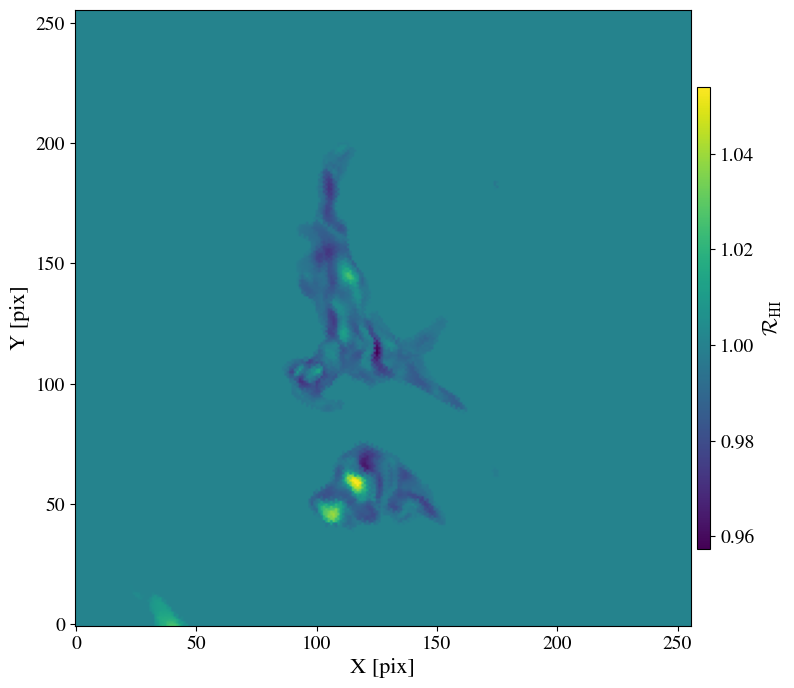

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(Y_data_pred_maps[:,:,1], cmap='viridis', origin='lower')

# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [pix]", fontsize=16)
ax.set_ylabel("Y [pix]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$\mathcal{R}_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

# Centralize the datacube


In [ ]:
# Centralize the data cube by appending noise to the 2 ends
noise_maps = [np.random.normal(0, noise, (ny,nx)) for _ in range(33)]

noise_std = np.stack(noise_maps, axis=0)
print(noise_std.shape)

# Append noise to the two ends of each spectrum
datacube = np.concatenate((noise_std, noise_std, data, noise_std), axis=0)
print(datacube.shape)

(33, 256, 256)
(238, 256, 256)


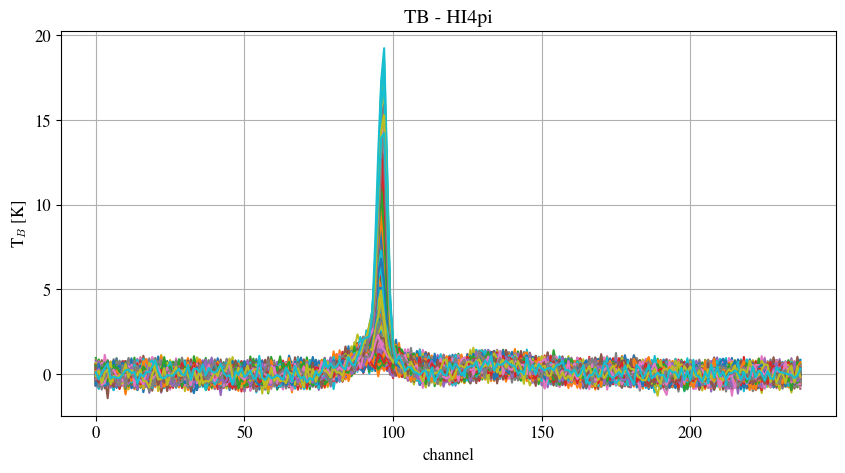

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(20,20):
    plt.plot(datacube[:, 80+j, 80+i])

plt.title('TB - HI4pi')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
plt.grid()
# fig.savefig('', bbox_inches='tight')
plt.show()

# Centralize and to new channel grid

In [ ]:
nchan, ny, nx = datacube.shape
print(nchan, ny, nx)

238 256 256


In [ ]:
# Interpolate into new vlsr channel grid
x = np.linspace(0, nchan, nchan, endpoint=False)
x[-3:]

array([235., 236., 237.])

In [ ]:
# Interpolate into new vlsr channel grid
nchan_new = 414
x_new = np.linspace(0, nchan, nchan_new, endpoint=True)
print(x_new[-3:])
print(x_new.shape)

new_cube = np.zeros((nchan_new, ny, nx))
for i,j in np.ndindex(nx,ny):
    new_cube[:, j, i] = np.interp(x_new, x, datacube[:, j, i])

[236.84745763 237.42372881 238.        ]
(414,)


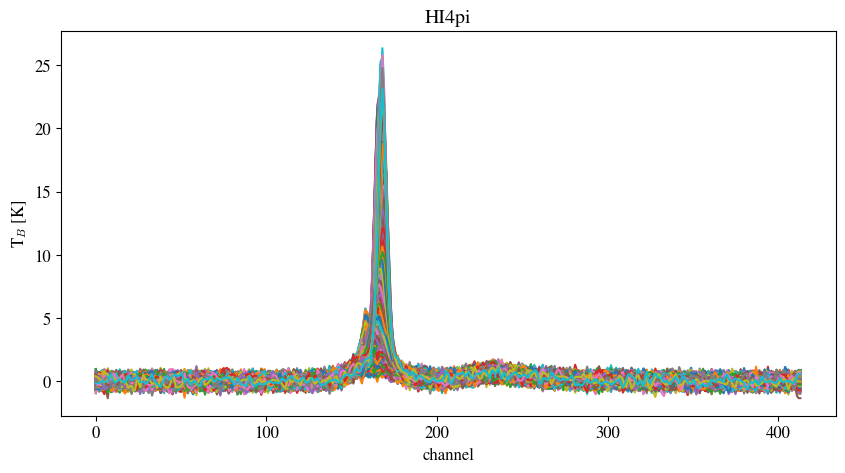

In [ ]:
fig = plt.figure(figsize=(10,5))

for i,j in np.ndindex(40,40):
    plt.plot(new_cube[:, 80+j, 80+i])

plt.title('HI4pi')
plt.xlabel('channel')
plt.ylabel('T$_B$ [K]')
# fig.savefig('', bbox_inches='tight')   # save the figure to file
plt.show()

In [ ]:
X_data = np.zeros((nx*ny, 414, 1))
X_data.shape

(65536, 414, 1)

In [ ]:
# Input shape as required by the CNN model
k = 0
for (i,j) in np.ndindex(nx,ny):
  X_data[k, :, 0] = new_cube[:, j, i]
  k = k + 1

In [ ]:
Y_data_pred = loaded_model.predict(X_data)
Y_data_pred

2048/2048 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step


array([[0.00727808, 1.0006331 ],
       [0.00727808, 1.0006331 ],
       [0.00727808, 1.0006331 ],
       ...,
       [0.00727808, 1.0006331 ],
       [0.00727808, 1.0006332 ],
       [0.00727808, 1.0006332 ]], dtype=float32)

In [ ]:
Y_data_pred_maps = np.reshape(Y_data_pred.copy(), (ny,nx,2), order='F')
Y_data_pred_maps.shape

(256, 256, 2)

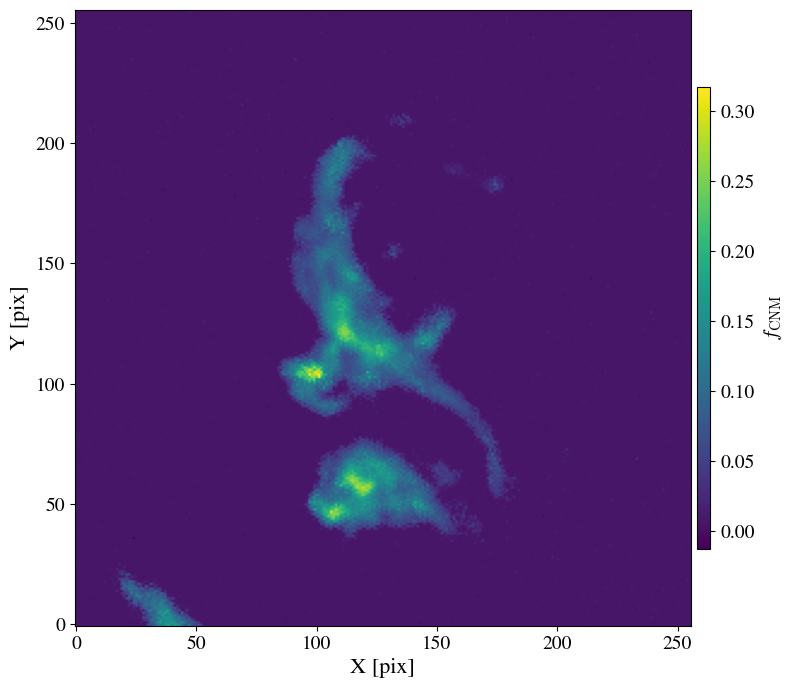

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(Y_data_pred_maps[:,:,0], cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [pix]", fontsize=16)
ax.set_ylabel("Y [pix]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$f_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

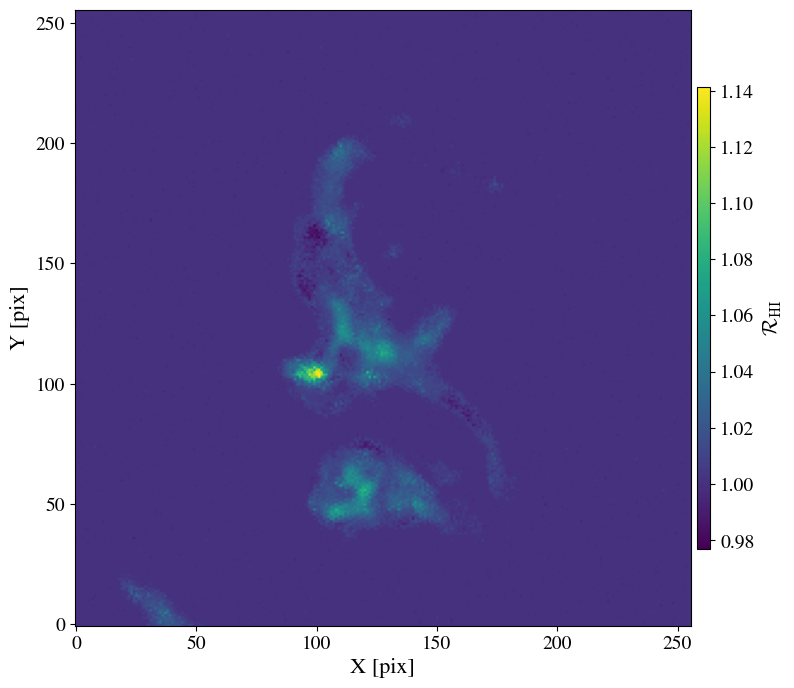

In [ ]:
# Plot
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(111)

# moment map image
im = ax.imshow(Y_data_pred_maps[:,:,1], cmap='viridis', origin='lower')


# Title
ax.set_title('', fontsize=14)

# Add axes labels
ax.set_xlabel("X [pix]", fontsize=16)
ax.set_ylabel("Y [pix]", fontsize=16)
ax.tick_params(labelsize=14)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.02, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$\mathcal{R}_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=15)
cbar.ax.tick_params(labelsize=14)

plt.show()
plt.close()

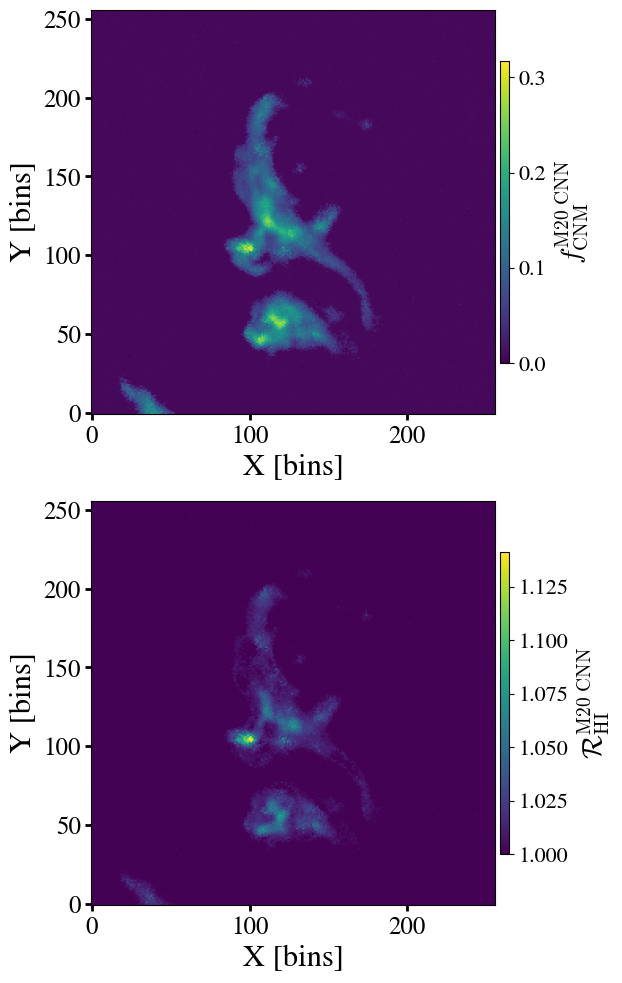

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211)



# moment map image
im = ax.imshow(Y_data_pred_maps[:,:,0], cmap='viridis', origin='lower', vmin=0.)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=22)
ax.set_ylabel("Y [bins]", fontsize=22)
ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel(r'$f^\mathrm{M20\ CNN}_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=20)
cbar.ax.tick_params(labelsize=16)







ax = fig.add_subplot(212)

# moment map image
im = ax.imshow(Y_data_pred_maps[:,:,1], cmap='viridis', origin='lower', vmin=1.)


# Add axes labels
ax.set_xlabel("X [bins]", fontsize=22)
ax.set_ylabel("Y [bins]", fontsize=22)

ax.tick_params(axis='x', labelsize=18, pad=4)
ax.tick_params(axis='y', labelsize=18)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.75, fraction=0.025, pad=0.006, aspect=35)
cbar.ax.set_ylabel('$\mathcal{R}^\mathrm{M20\ CNN}_\mathrm{HI}$', rotation=90, labelpad=5., fontsize=20)
cbar.ax.tick_params(labelsize=16)




# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

plt.tight_layout()
plt.show()
plt.close()

In [ ]:
fcnm_cnn_cen = Y_data_pred_maps[:,:,0]
rhi_cnn_cen  = Y_data_pred_maps[:,:,1]

# CNN-Transformer

In [ ]:
ctrans_fcnm_rhi_npz_file = hi4pi_data_path / 'ctrans_fcnm_rhi.npz'
print(os.path.exists(ctrans_fcnm_rhi_npz_file))

npzfile = np.load(ctrans_fcnm_rhi_npz_file)
Fcnm = npzfile['x']
Rhi = npzfile['y']

True


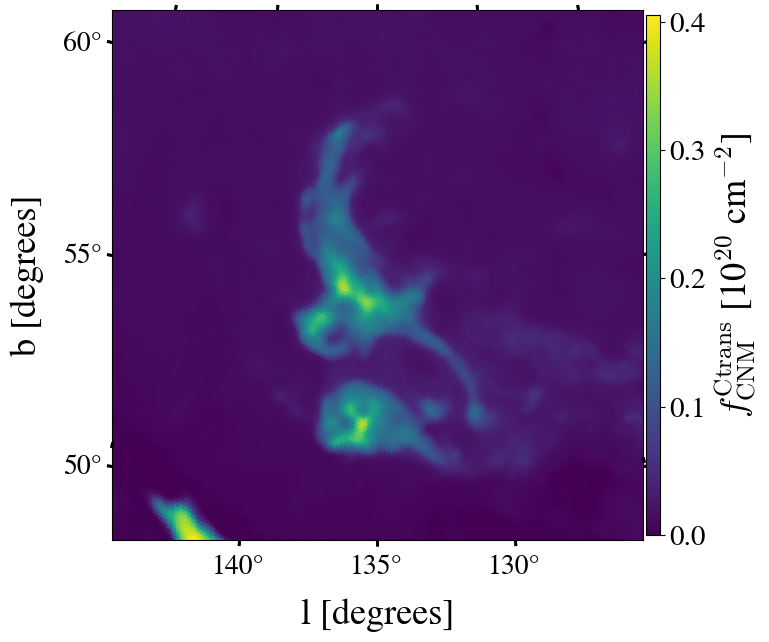

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=WCS(target_header))

tlbs = 20
xlbs = 26


# moment map image
im = ax.imshow(Fcnm, cmap='viridis', origin='lower', vmin=0.)


# Add axes labels
ax.set_xlabel("l [degrees]", fontsize=xlbs)
ax.set_ylabel("b [degrees]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$f^\mathrm{Ctrans}_\mathrm{CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=26)
cbar.ax.tick_params(labelsize=21)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

# nhi_ctrans_vs_rohsa_uma.png
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
nhi_cnm_cnn_cen = nhi_thin * rhi_cnn_cen * fcnm_cnn_cen

# M20 CNN (from Marchal et al. 2024)

In [ ]:
def change_coord(m, coord):
    """ Change coordinates of a HEALPIX map
    Parameters
    ----------
    m : map or array of maps
      map(s) to be rotated
    coord : sequence of two character
      First character is the coordinate system of m, second character
      is the coordinate system of the output map. As in HEALPIX, allowed
      coordinate systems are 'G' (galactic), 'E' (ecliptic) or 'C' (equatorial)
    Example
    -------
    The following rotate m from galactic to equatorial coordinates.
    Notice that m can contain both temperature and polarization.
    >>>> change_coord(m, ['G', 'C'])
    """
    # Basic HEALPix parameters
    npix = m.shape[-1]
    nside = hp.npix2nside(npix)
    ang = hp.pix2ang(nside, np.arange(npix))
    # Select the coordinate transformation
    rot = hp.Rotator(coord=reversed(coord))
    # Convert the coordinates
    new_ang = rot(*ang)
    new_pix = hp.ang2pix(nside, *new_ang)
    return m[..., new_pix]




def set_wcs(patch_size, projx, projy, cdelt, GLON, GLAT):
    w           = WCS(naxis=2)
    w.wcs.crpix = [patch_size/2, patch_size/2]
    w.wcs.crval = [GLON, GLAT]
    w.wcs.cdelt = np.array([-cdelt,cdelt])
    w.wcs.ctype = [projx, projy]
    return w

In [ ]:
fcnm_cnn_hi4pi_hpx_file = os.path.join(hi4pi_data_path, 'fcnm_hi4pi_hpx.fits')
os.path.exists(fcnm_cnn_hi4pi_hpx_file)

True

In [ ]:
fcnm_cnn = hp.read_map(fcnm_cnn_hi4pi_hpx_file, field=None)

In [ ]:
fcnm_cnn_G = change_coord(fcnm_cnn, ['C', 'G'])

In [ ]:
# Locate HPX file with LOS
glon = 135.
glat = 55.

c = SkyCoord(glon*u.deg, glat*u.deg, frame='galactic')

reso = 0.05
size = 256
target_wcs = set_wcs(size, 'GLON-TAN', 'GLAT-TAN', reso, c.l.value, c.b.value)
target_header = target_wcs.to_header()

In [ ]:
proj_fcnm_CNN_anom, foo = reproject_from_healpix((fcnm_cnn_G,'g'), target_header, shape_out=(size,size), order=0, nested=False)

<Figure size 1600x1200 with 0 Axes>

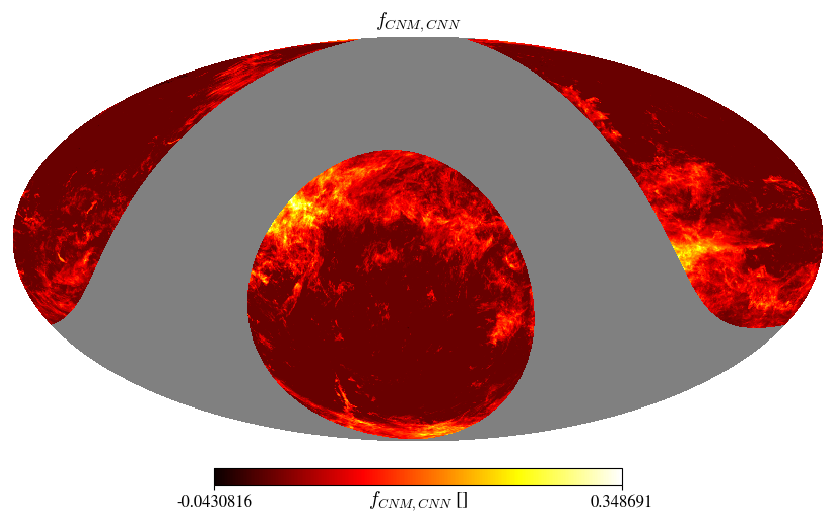

In [ ]:
plt.figure(figsize=(16, 12))

# Visualize the HEALPix map using mollview
hp.mollview(fcnm_cnn, title='$f_{CNM,CNN}$', cmap='hot', unit='$f_{CNM,CNN}$ []')

mpl.rcParams.update({'font.size':12})
plt.show()
plt.close('all')

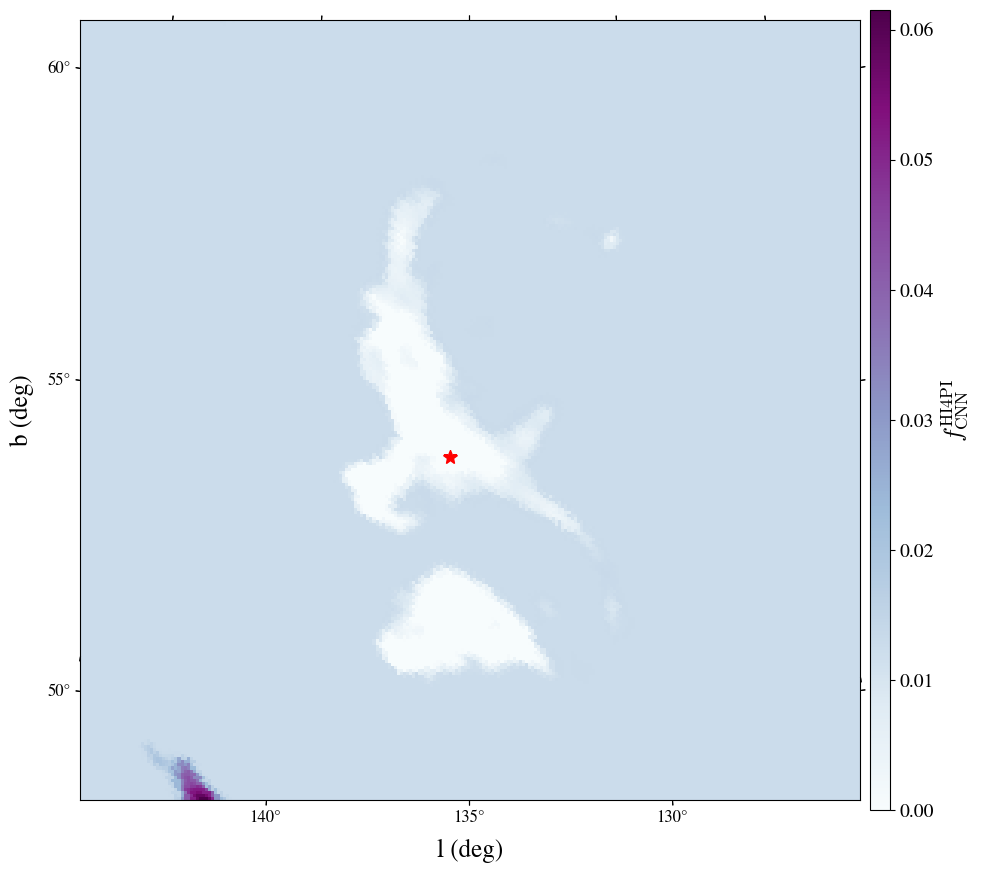

In [ ]:
#PLOTS
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=WCS(target_header))

ax.set_xlabel(r"l (deg)", fontsize=18.)
ax.set_ylabel(r"b (deg)", fontsize=18.)
img = ax.imshow(proj_fcnm_CNN_anom, vmin=0, origin="lower", cmap="BuPu")
ax.plot(121,112, "*", ms=10, color="r")
colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$f_{\rm CNN}^{\rm HI4PI}$", fontsize=18.)
plt.show()

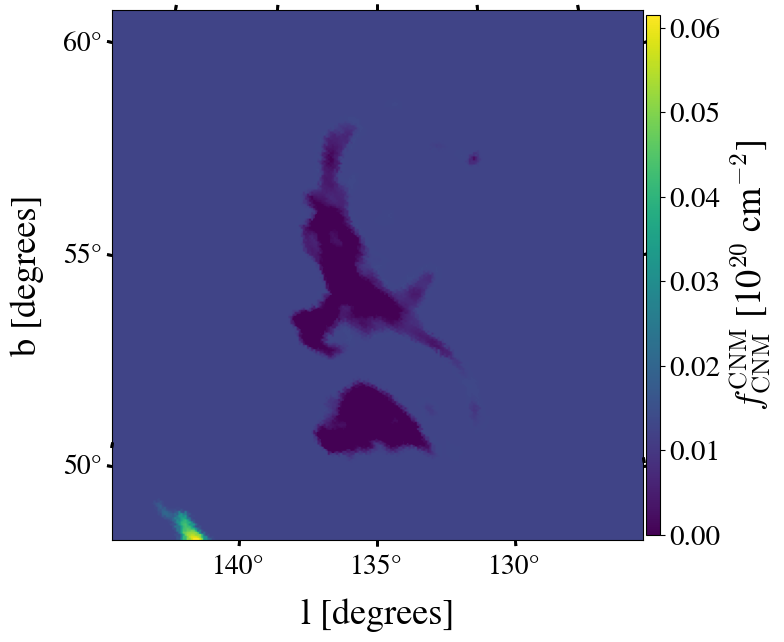

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=WCS(target_header))

tlbs = 20
xlbs = 26

# moment map image
im = ax.imshow(proj_fcnm_CNN_anom, cmap='viridis', origin='lower', vmin=0.)


# Add axes labels
ax.set_xlabel("l [degrees]", fontsize=xlbs)
ax.set_ylabel("b [degrees]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$f^\mathrm{CNM}_\mathrm{CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=26)
cbar.ax.tick_params(labelsize=21)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

# nhi_ctrans_vs_rohsa_uma.png
plt.tight_layout()
plt.show()
plt.close()

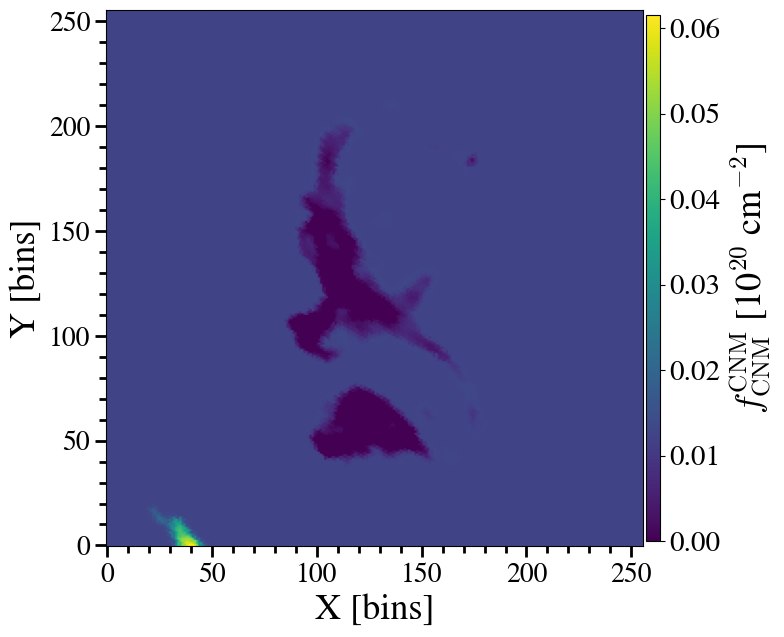

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)

tlbs = 20
xlbs = 26


# moment map image
im = ax.imshow(proj_fcnm_CNN_anom, cmap='viridis', origin='lower', vmin=0.)

# Add axes labels
ax.set_xlabel("X [bins]", fontsize=xlbs)
ax.set_ylabel("Y [bins]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$f^\mathrm{CNM}_\mathrm{CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=26)
cbar.ax.tick_params(labelsize=21)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

# nhi_ctrans_vs_rohsa_uma.png
plt.tight_layout()
plt.show()
plt.close()

# RHI  (from Marchal et al. 2024)

In [ ]:
rhi_cnn_hi4pi_hpx_file = os.path.join(hi4pi_data_path, 'rhi_hi4pi_hpx.fits')
os.path.exists(rhi_cnn_hi4pi_hpx_file)

True

In [ ]:
rhi_cnn = hp.read_map(rhi_cnn_hi4pi_hpx_file, field=None)
rhi_cnn.shape

(12582912,)

In [ ]:
rhi_cnn_G = change_coord(rhi_cnn, ['C', 'G'])

In [ ]:
proj_rhi_CNN_anom, foo = reproject_from_healpix((rhi_cnn_G,'g'), target_header, shape_out=(size,size), order=0, nested=False)

<Figure size 1600x1200 with 0 Axes>

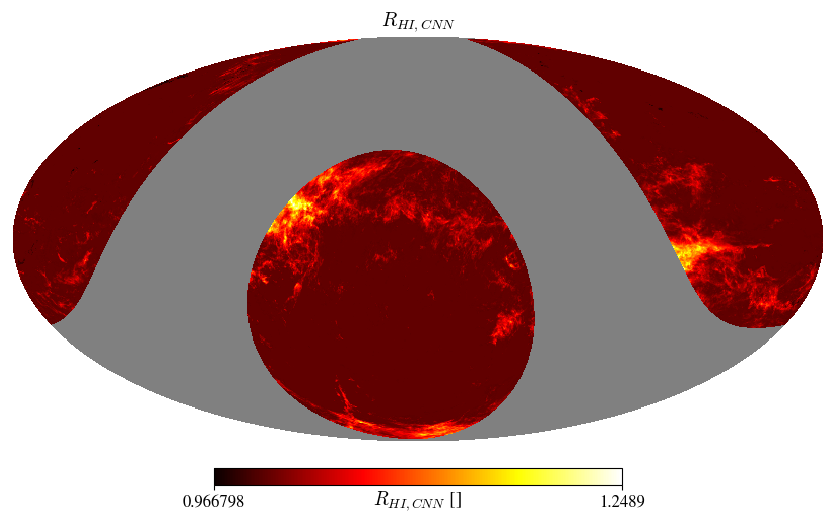

In [ ]:
plt.figure(figsize=(16, 12))

# Visualize the HEALPix map using mollview
hp.mollview(rhi_cnn, title='$R_{HI,CNN}$', cmap='hot', unit='$R_{HI,CNN}$ []')

mpl.rcParams.update({'font.size':12})
plt.show()
plt.close('all')

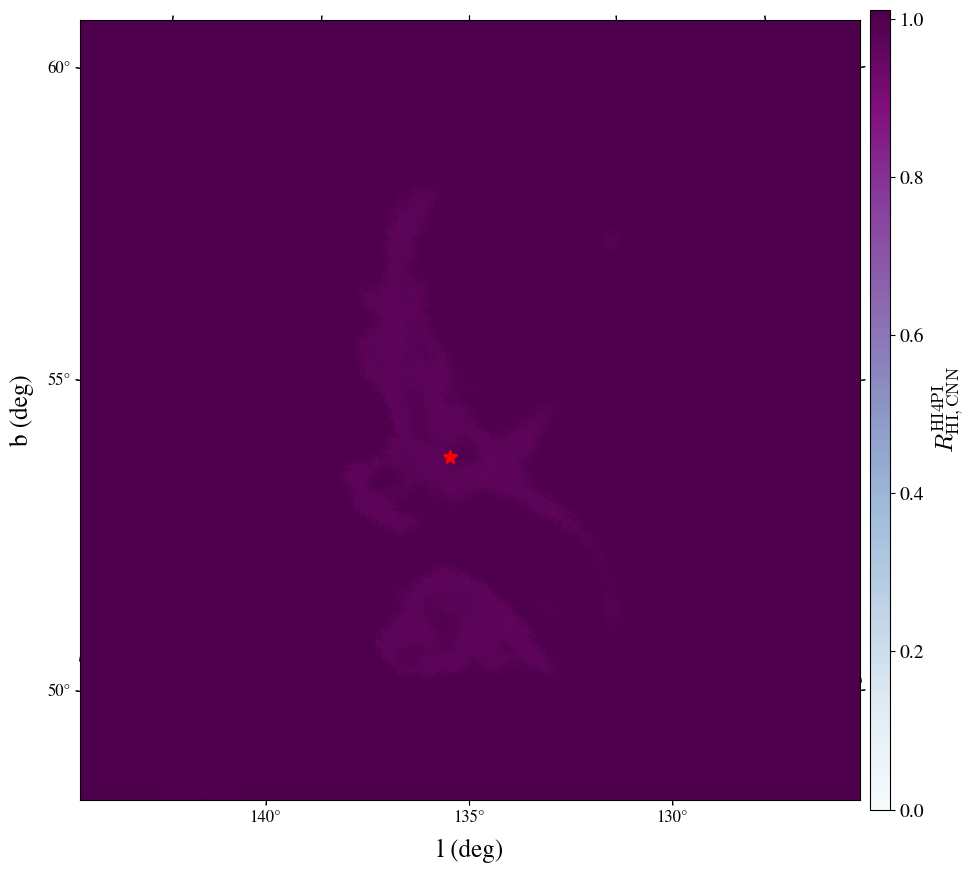

In [ ]:
#PLOTS
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=WCS(target_header))

ax.set_xlabel(r"l (deg)", fontsize=18.)
ax.set_ylabel(r"b (deg)", fontsize=18.)
img = ax.imshow(proj_rhi_CNN_anom, vmin=0, origin="lower", cmap="BuPu")

ax.plot(121,112, "*", ms=10, color="r")
colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$R_{\rm HI,CNN}^{\rm HI4PI}$", fontsize=18.)
plt.show()

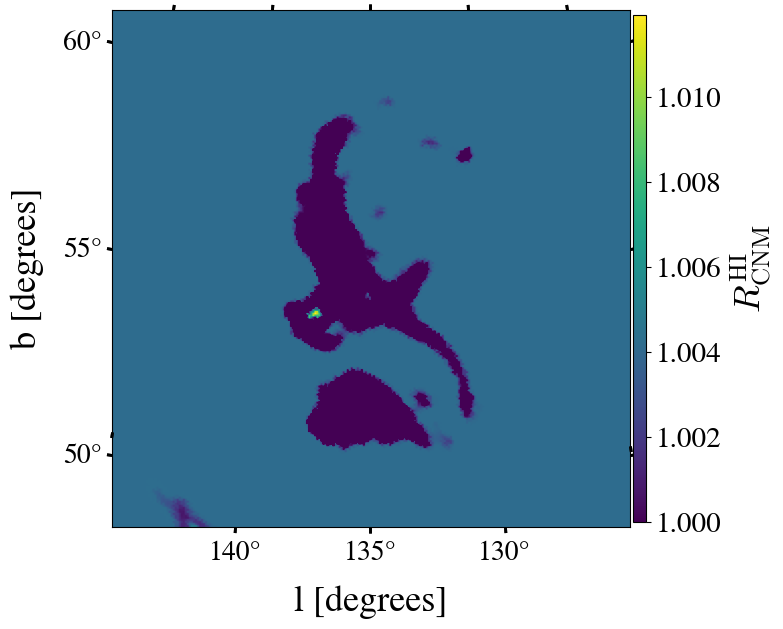

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=WCS(target_header))

tlbs = 20
xlbs = 26



# moment map image
im = ax.imshow(proj_rhi_CNN_anom, cmap='viridis', origin='lower', vmin=1.)

# Add axes labels
ax.set_xlabel("l [degrees]", fontsize=xlbs)
ax.set_ylabel("b [degrees]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$R^\mathrm{HI}_\mathrm{CNM}$', rotation=90, labelpad=5., fontsize=26)
cbar.ax.tick_params(labelsize=21)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

# nhi_ctrans_vs_rohsa_uma.png
plt.tight_layout()
plt.show()
plt.close()

# CNM FFT (from Marchal et al. 2024)

In [ ]:
fmin_hi4pi_hpx_file = os.path.join(hi4pi_data_path, 'fmin_hsfft_full.fits')
os.path.exists(fmin_hi4pi_hpx_file)

True

In [ ]:
fcnm_min = hp.read_map(fmin_hi4pi_hpx_file)
proj_fcnm_FFT_anom, foo = reproject_from_healpix((fcnm_min,'g'), target_header, shape_out=(size,size), order=0, nested=False)

<Figure size 1600x1200 with 0 Axes>

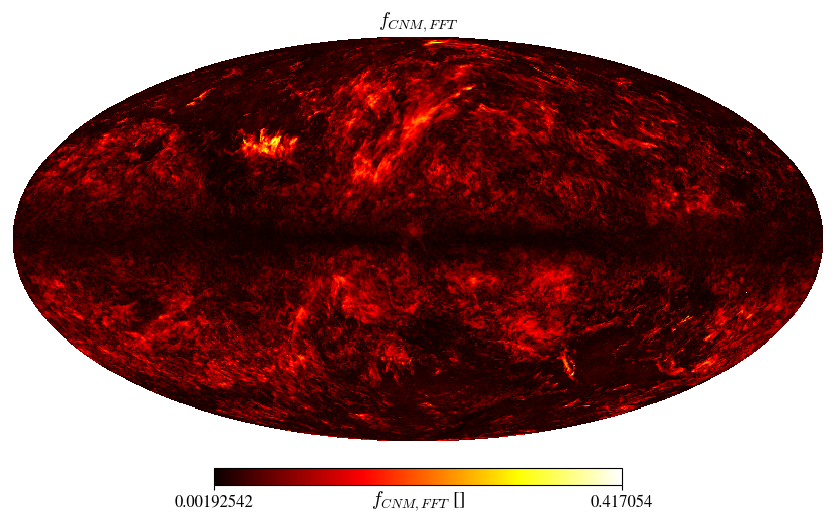

In [ ]:
plt.figure(figsize=(16, 12))

# Visualize the HEALPix map using mollview
hp.mollview(fcnm_min, title='$f_{CNM,FFT}$', cmap='hot', unit='$f_{CNM,FFT}$ []')

mpl.rcParams.update({'font.size':12})
plt.show()
plt.close('all')

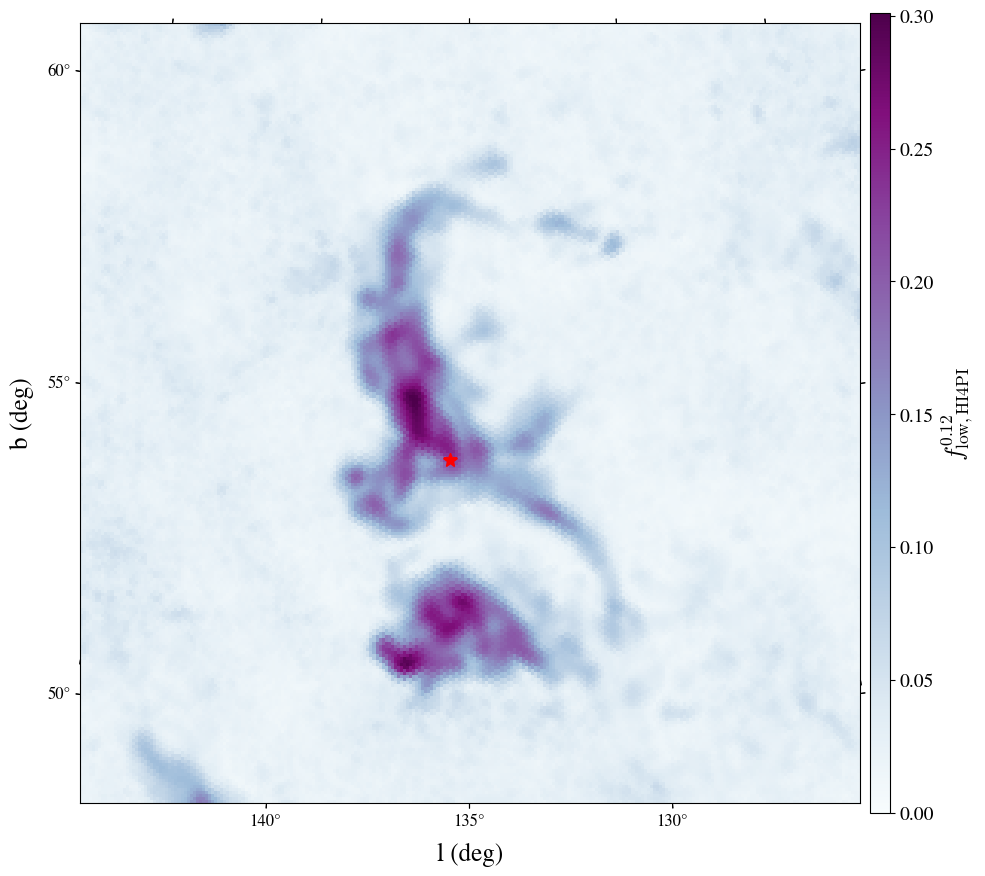

In [ ]:
#PLOTS
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=WCS(target_header))
ax.set_xlabel(r"l (deg)", fontsize=18.)
ax.set_ylabel(r"b (deg)", fontsize=18.)
img = ax.imshow(proj_fcnm_FFT_anom, vmin=0, origin="lower", cmap="BuPu")
ax.plot(121,112, "*", ms=10, color="r")

colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$f_{\rm low, HI4PI}^{0.12}$", fontsize=18.)
plt.show()


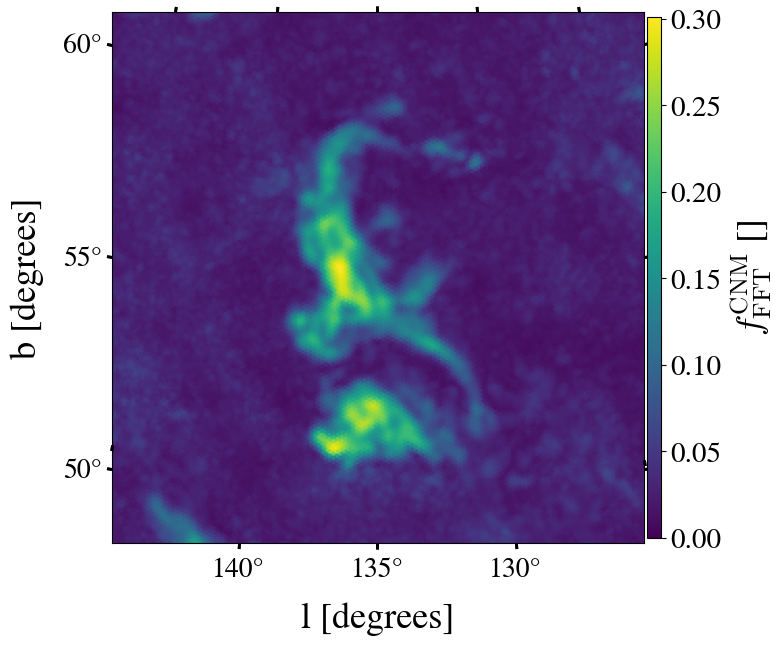

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=WCS(target_header))

tlbs = 20
xlbs = 26



# moment map image
im = ax.imshow(proj_fcnm_FFT_anom, cmap='viridis', origin='lower', vmin=0.)


# Add axes labels
ax.set_xlabel("l [degrees]", fontsize=xlbs)
ax.set_ylabel("b [degrees]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$f^\mathrm{CNM}_\mathrm{FFT}$ []', rotation=90, labelpad=5., fontsize=26)
cbar.ax.tick_params(labelsize=21)

# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

# nhi_ctrans_vs_rohsa_uma.png
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
nhi_thin = tb_sum*0.018224*dv

In [ ]:
nhi_cnm_fft = proj_fcnm_FFT_anom * nhi_thin

In [ ]:
nhi_cnm_ct = nhi_thin * Rhi * Fcnm

In [ ]:
nhi_cnm_cnn = nhi_thin * proj_rhi_CNN_anom * proj_fcnm_CNN_anom

# CNM FFT

In [ ]:
fmin_hi4pi_hpx_file = hi4pi_data_path / 'fmin_hsfft_full.fits'
os.path.exists(fmin_hi4pi_hpx_file)

True

In [ ]:
fcnm_min = hp.read_map(fmin_hi4pi_hpx_file)
proj_fcnm_FFT_anom, foo = reproject_from_healpix((fcnm_min,'g'), target_header, shape_out=(size,size), order=0, nested=False)

<Figure size 1600x1200 with 0 Axes>

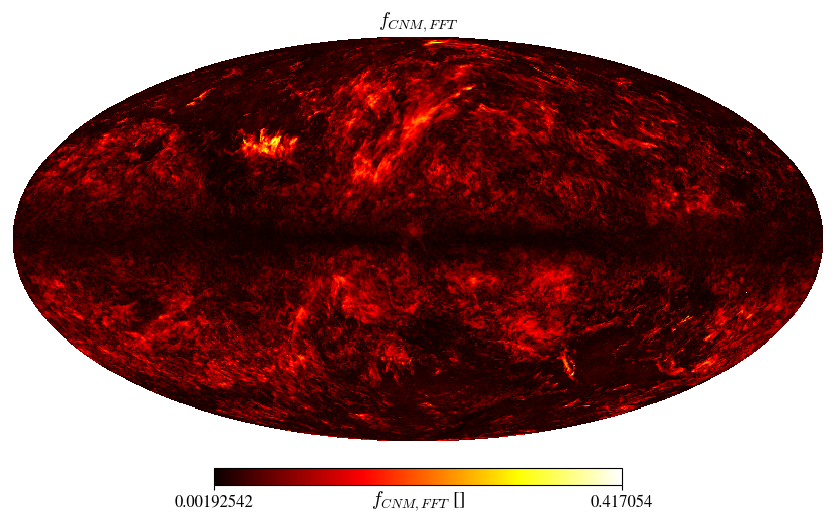

In [ ]:
plt.figure(figsize=(16, 12))

# Visualize the HEALPix map using mollview
hp.mollview(fcnm_min, title='$f_{CNM,FFT}$', cmap='hot', unit='$f_{CNM,FFT}$ []') # , min=0., max=4.25 norm='log',  min=0., max=4.25
# plt.savefig(base_path / f'av_map_1248pc_hp.png', bbox_inches='tight')   # save the figure to file

mpl.rcParams.update({'font.size':12})
plt.show()
plt.close('all')

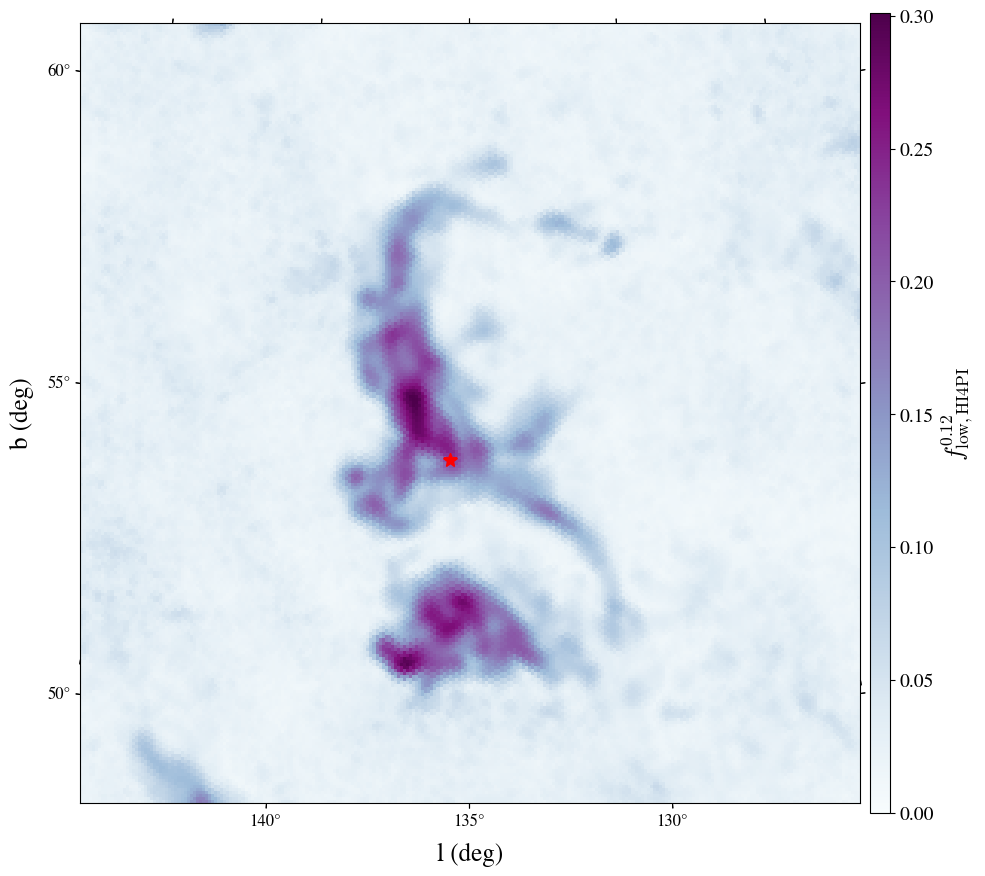

In [ ]:
#PLOTS
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1,0.1,0.78,0.8], projection=WCS(target_header))
ax.set_xlabel(r"l (deg)", fontsize=18.)
ax.set_ylabel(r"b (deg)", fontsize=18.)
img = ax.imshow(proj_fcnm_FFT_anom, vmin=0, origin="lower", cmap="BuPu")
ax.plot(121,112, "*", ms=10, color="r")

colorbar_ax = fig.add_axes([0.89, 0.1, 0.02, 0.8])
cbar = fig.colorbar(img, cax=colorbar_ax)
cbar.ax.tick_params(labelsize=14.)
cbar.set_label(r"$f_{\rm low, HI4PI}^{0.12}$", fontsize=18.)
# plt.savefig("plot/" + 'fcnm_map_IVC_anom_FFT.png', format='png', bbox_inches='tight', pad_inches=0.02)
plt.show()


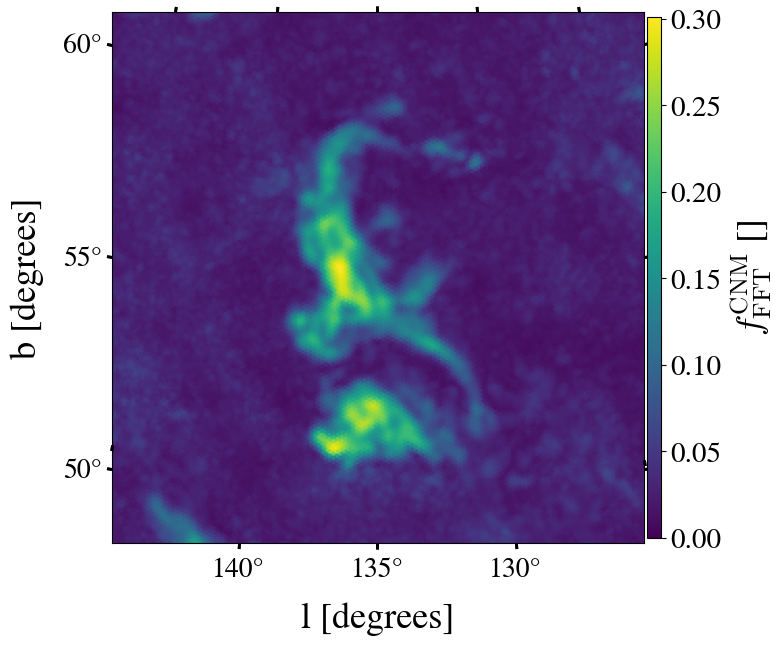

In [ ]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection=WCS(target_header))

tlbs = 20
xlbs = 26


# moment map image
im = ax.imshow(proj_fcnm_FFT_anom, cmap='viridis', origin='lower', vmin=0.)


# Add axes labels
ax.set_xlabel("l [degrees]", fontsize=xlbs)
ax.set_ylabel("b [degrees]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$f^\mathrm{CNM}_\mathrm{FFT}$ []', rotation=90, labelpad=5., fontsize=26)
cbar.ax.tick_params(labelsize=21)



# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=0.001,
                    hspace=0.1
                    )

# nhi_ctrans_vs_rohsa_uma.png
plt.tight_layout()
plt.show()
plt.close()

# tpcNet vs M20 CNN: HI4PI IVC Figure 17

In [ ]:
wcs_2D = WCS(target_header)

<ipython-input-668-244f7204923c>:283: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


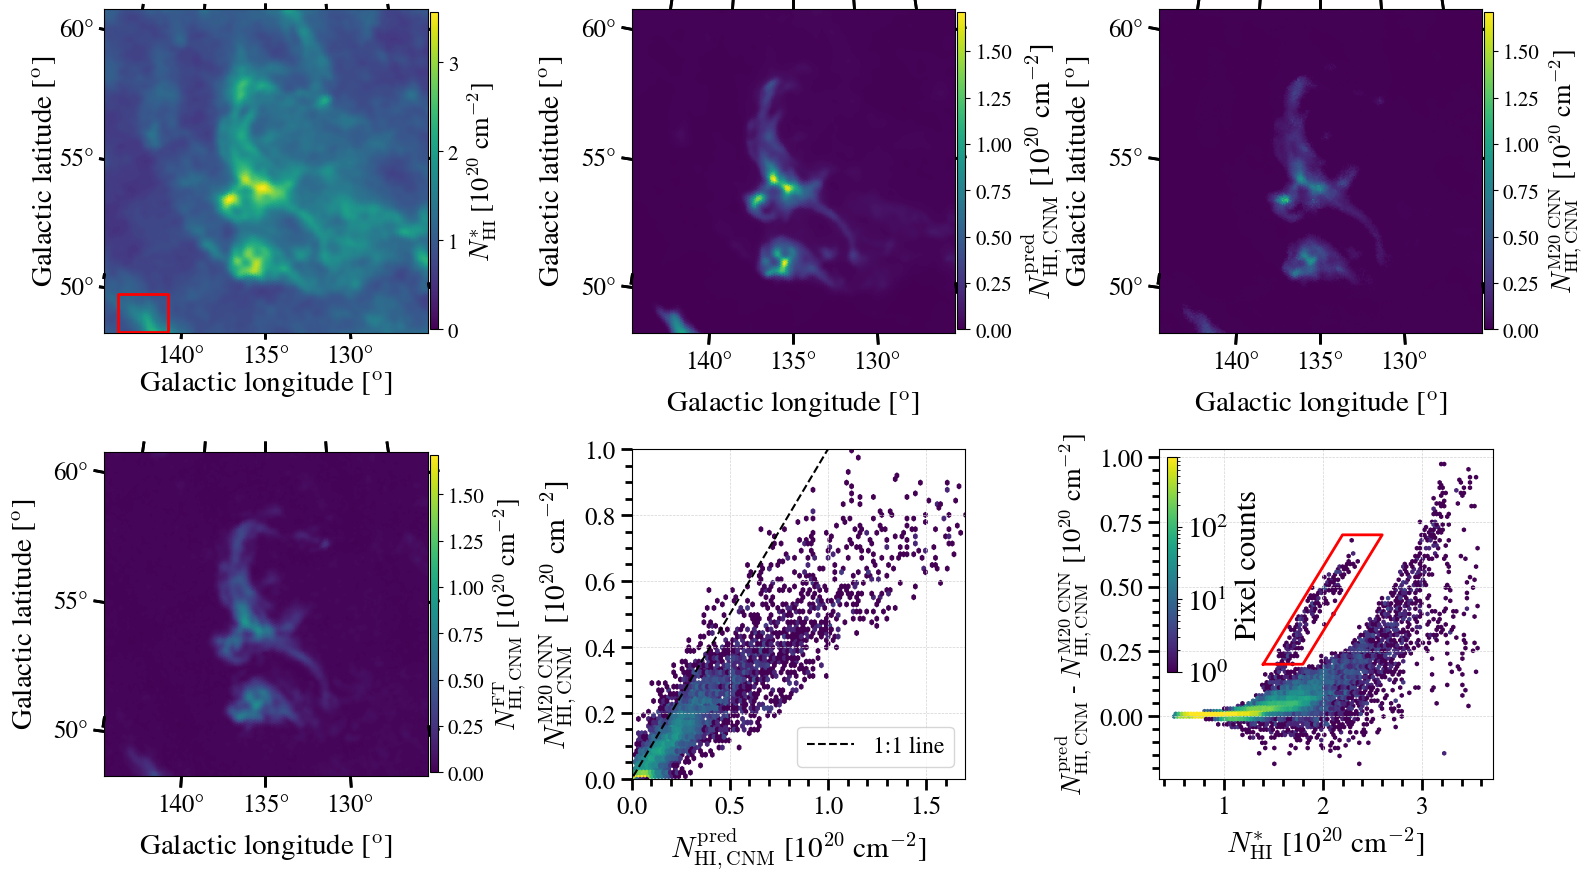

In [ ]:
fig = plt.figure(figsize=(16,9))

tlbs = 18
xlbs = 21
normalizer = LogNorm(1., 9.e2)




# ax
ax = fig.add_subplot(231, projection=wcs_2D)


# moment map image
im = ax.imshow(nhi_thin, cmap='viridis', origin='lower', vmin=0.)

x_points = [10., 50., 50, 10, 10]
y_points = [0., 0., 30, 30, 0.]

# Plot the box
ax.plot(x_points, y_points, color='red', linewidth=2)


# Add axes labels
ax.set_ylabel("Galactic latitude [$^\mathrm{o}$]", fontsize=xlbs, labelpad=0.5)
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=xlbs, labelpad=0.5)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=4)
ax.tick_params(which='minor', length=2)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$N^\mathrm{*}_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=19)
cbar.ax.tick_params(labelsize=15)




#
ax = fig.add_subplot(234, projection=wcs_2D)

# moment map image
im = ax.imshow(nhi_cnm_fft, cmap='viridis', origin='lower', vmin=0., vmax=1.71)

# Add axes labels
ax.set_ylabel("Galactic latitude [$^\mathrm{o}$]", fontsize=xlbs)
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$N^\mathrm{FT}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=19)
cbar.ax.tick_params(labelsize=15)




#
ax = fig.add_subplot(233, projection=wcs_2D)

# moment map image
im = ax.imshow(nhi_cnm_cnn_cen, cmap='viridis', origin='lower', vmin=0., vmax=1.71)

# Add axes labels
ax.set_ylabel("Galactic latitude [$^\mathrm{o}$]", fontsize=xlbs)
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$N^\mathrm{M20\ CNN}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=19)
cbar.ax.tick_params(labelsize=15)






ax = fig.add_subplot(232, projection=wcs_2D)

# moment map image
im = ax.imshow(nhi_cnm_ct, cmap='viridis', origin='lower', vmin=0., vmax=1.71)

# Add axes labels
ax.set_ylabel("Galactic latitude [$^\mathrm{o}$]", fontsize=xlbs)
ax.set_xlabel("Galactic longitude [$^\mathrm{o}$]", fontsize=xlbs)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)

## Color bar
cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.99, fraction=0.025, pad=0.006, aspect=38)
cbar.ax.set_ylabel(r'$N^\mathrm{pred}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', rotation=90, labelpad=5., fontsize=21)
cbar.ax.tick_params(labelsize=15)






ax = fig.add_subplot(235)

img = ax.hexbin(nhi_cnm_ct, nhi_cnm_cnn_cen, gridsize=100, cmap='viridis', norm=normalizer)
ax.plot([-0.05, 1.4], [-0.05, 1.4], 'k--', label='1:1 line')

ax.set_ylabel(r'$N^\mathrm{M20\ CNN}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', fontsize=xlbs)
ax.set_xlabel(r'$N^\mathrm{pred}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', fontsize=xlbs)

ax.set_xlim(0., 1.7)
ax.set_ylim(0., 1.)

ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)
# ax.set_aspect('equal')

ax.legend(loc='lower right', fancybox=True, framealpha=0.8, labelcolor='k', fontsize=xlbs-4)
ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)







ax = fig.add_subplot(236)

img = ax.hexbin(nhi_thin.flatten(), nhi_cnm_ct.flatten() - nhi_cnm_cnn_cen.flatten(), gridsize=100, cmap='viridis', norm=normalizer)

x_points = [1.4, 2.2, 2.6, 1.8, 1.4]
y_points = [0.2, 0.7, 0.7, 0.2, 0.2]

# Plot the box
ax.plot(x_points, y_points, color='red', linewidth=2)

axins1 = inset_axes(ax,
                    width="3%",  # width: 50% of parent_bbox width
                    height="65%",  # height: 5%
                    loc="upper left",
                    )
axins1.xaxis.set_ticks_position("bottom")
cbar = fig.colorbar(img,
                    cax=axins1,
                    orientation='vertical',
                    fraction=0.02,
                    pad=0.01, aspect=95)
cbar.ax.set_ylabel('Pixel counts', rotation=90, labelpad=5., fontsize=22)
cbar.ax.tick_params(labelsize=21)

ax.set_ylabel(r'$N^\mathrm{pred}_\mathrm{HI, CNM}$ - $N^\mathrm{M20\ CNN}_\mathrm{HI, CNM}$ [10$^{20}$ cm$^{-2}$]', fontsize=xlbs-2)
ax.set_xlabel(r'$N^\mathrm{*}_\mathrm{HI}$ [10$^{20}$ cm$^{-2}$]', fontsize=xlbs)


ax.minorticks_on()
ax.tick_params(axis='x', labelsize=tlbs, pad=4)
ax.tick_params(axis='y', labelsize=tlbs)
ax.tick_params(which='both', width=2)
ax.tick_params(which='major', length=8)
ax.tick_params(which='minor', length=5)
# ax.set_aspect('equal')

ax.grid(True, linestyle='--', linewidth=0.5, color='lightgray', zorder=-10)


# set the spacing between subplots
plt.subplots_adjust(left=None,
                    bottom=None,
                    right=None,
                    top=None,
                    wspace=5.5,
                    hspace=0.5
                    )

plt.tight_layout()
plt.show()
plt.close()

End